In [1]:
global modality_dims
import numpy as np
import nibabel as nib
from nilearn import datasets, plotting
from nilearn.maskers import NiftiLabelsMasker
from matplotlib.colors import ListedColormap, to_rgba
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
def compute_encoding_accuracy(fmri_val, fmri_val_pred, subject, modality):


    ### Correlate recorded and predicted fMRI responses ###
    encoding_accuracy = np.zeros((fmri_val.shape[1]), dtype=np.float32)
    for p in range(len(encoding_accuracy)):
        encoding_accuracy[p] = pearsonr(fmri_val[:, p],
            fmri_val_pred[:, p])[0]
    mean_encoding_accuracy = np.mean(encoding_accuracy)
    

    return mean_encoding_accuracy




In [3]:
def concat_subjects(targets: dict, axis: int = 0) -> dict:
    subj_collect = {}
    for movie, subj_dict in targets.items():
        for subj_id, arr in subj_dict.items():
            subj_collect.setdefault(subj_id, []).append(arr)
    # now concatenate each subject’s list of arrays
    return { subj_id: np.concatenate(arrs, axis=axis)
             for subj_id, arrs in subj_collect.items() }


def concat_movies(targets: dict, axis: int = 0) -> dict:
    movie_concat = {}
    for movie, subj_dict in targets.items():
        # take all arrays for this movie and concatenate them
        arrays = list(subj_dict.values())
        movie_concat[movie] = np.concatenate(arrays, axis=axis)
    return movie_concat



def get_epoch_out(targets: dict, epoch: int):
    new_dict = {}
    for movie in targets.keys():
        new_dict[movie] = {}
        for subject in targets[movie][0].keys():
            new_dict[movie][subject] = targets[movie][epoch][subject]
    return new_dict



In [4]:
def compute_lw_net_scores(lw_dict):
    """
    For each movie & subject, picks the epoch with highest parcel‑mean Pearson r,
    then aggregates those best‑epoch parcel scores into network & movie averages.
    """
    movie_net_means = []
    for movie, epochs in lw_dict.items():
        net_lists = defaultdict(list)
        # assume every epoch has same subject keys; grab subjects from first epoch
        subjects = next(iter(epochs.values())).keys()
        for subj in subjects:
            best_acc = None
            best_score = -np.inf
            y_true_subj = y_true_dict[movie][subj]
            for epoch, subj_preds in epochs.items():
                pred = subj_preds[subj]
                parcel_acc = pearson_per_parcel(y_true_subj, pred)
                mean_acc = np.nanmean(parcel_acc)
                if mean_acc > best_score:
                    best_score = mean_acc
                    best_acc = parcel_acc
            # distribute best_acc into network lists
            for idx, sc in enumerate(best_acc, start=1):
                net = _parcel_to_network(id_to_name[idx])
                net_lists[net].append(sc)
        movie_net_means.append({net: np.nanmean(v) for net, v in net_lists.items()})
    net_to_vals = defaultdict(list)
    for m in movie_net_means:
        for net, sc in m.items():
            net_to_vals[net].append(sc)
    return {net: np.nanmean(v) for net, v in net_to_vals.items()}

In [5]:
from nilearn.datasets import fetch_atlas_schaefer_2018

sch = fetch_atlas_schaefer_2018(n_rois=1000, yeo_networks=7)
labels = sch["labels"]
id_to_name = {
    i: (lab.decode() if isinstance(lab, (bytes, bytearray)) else lab)
    for i, lab in enumerate(labels, start=1)
}

def _parcel_to_network(label: str) -> str:
    return label.split("_")[2]  # e.g. "7Networks_RH_Vis_17" → "Vis"

# ---------------------------------------------------------------------
# 3.  Helper: Pearson‑r per parcel
# ---------------------------------------------------------------------
def pearson_per_parcel(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    return np.array([
        pearsonr(y_true[:, i], y_pred[:, i])[0]
        for i in range(y_true.shape[1])
    ])


[get_dataset_dir] Dataset found in /u/denizkucuk/nilearn_data/schaefer_2018

## Read Results

In [6]:
import numpy as np
from collections import defaultdict, OrderedDict


models = OrderedDict([
    ("Ablation1", np.load("no_modalities_no_separation.npy", allow_pickle=True).item()),
    ("Ablation2",    np.load("no_separation.npy",              allow_pickle=True).item()),
    ("Ablation3",    np.load("no_modalities.npy",              allow_pickle=True).item()),
    ("Non-Ablation", np.load("final.npy",                      allow_pickle=True).item()),
    ("lstm_lstm_mse_negcorr", np.load("final.npy",                      allow_pickle=True).item()),
    ("lstm_lstm_mse", np.load("lstm_lstm_mse.npy",                      allow_pickle=True).item()),
    ("lstm_gru_mse", np.load("lstm_gru_mse.npy",                      allow_pickle=True).item()),
    ("lstm_lstm_mse_negcorr", np.load("lstm_gru_corr.npy",                      allow_pickle=True).item()),
    ("early_late", np.load("loss_weight.npy",                      allow_pickle=True).item())
])



y_true_dict = np.load("targets.npy", allow_pickle=True).item()


In [7]:
from collections import OrderedDict
import numpy as np


selected = ["lstm_lstm_mse_negcorr", "lstm_lstm_mse","lstm_gru_mse","lstm_lstm_mse_negcorr"]
n = len(selected)
movies   = models[selected[0]].keys()
subjects = lambda mv: models[selected[0]][mv].keys()

ensemble = {
    mv: {
        subj: sum(models[name][mv][subj] for name in selected) / n
        for subj in subjects(mv)
    }
    for mv in movies
}

# 6) (Optional) stick it back into your main dict
models["final_ensemble"] = ensemble

# 7) (Optional) recompute any metrics on it
# models["ensemble_two"] = compute_lw_net_scores(ensemble_two)


In [8]:


pretty = {
    "Ablation1": "Unified-Modality and Single Head",
    "Ablation2": "Single Head",
    "Ablation3": "Unified-Modality",
    "Non-Ablation": "Modality-Seperated Head",
    "lstm_lstm_mse_negcorr": "LSTM-LSTM (MSE + NegCorr)",
    "lstm_lstm_mse": "LSTM-LSTM (MSE)",
    "lstm_gru_mse": "LSTM-GRU (MSE)",
    "lstm_gru_mse_negcorr": "LSTM-GRU (MSE + NegCorr)",
    "early_late": "Early-Late Curriculum",
    "final_ensemble": "Final Ensemble"
}


In [9]:
from scipy.stats import pearsonr

model_net_scores = {}    # final result {model: {network: score}}

for model_name, pred_dict in models.items():

    # movie‑level aggregation first
    movie_net_means = []   # list of dicts, one per movie

    for movie, subj_preds in pred_dict.items():
        net_lists = defaultdict(list)   # network → list[subject_score]

        # ---- subject loop ---------------------------------------------------
        for sid, pred in subj_preds.items():
            y_true = y_true_dict[movie][sid]

            # ---- choose the right parcel‑level accuracy:
            #    *If your arrays already store accuracies, replace the line below with:*
            #      parcel_acc = pred.mean(axis=0)
            parcel_acc = pearson_per_parcel(y_true, pred)

            # ---- parcel → network mean --------------------------------------
            for idx, sc in enumerate(parcel_acc, start=1):           # idx = 1…1000
                net = _parcel_to_network(id_to_name[idx])
                net_lists[net].append(sc)

        # average across subjects → one score per network, per movie
        movie_net_means.append({net: np.nanmean(v) for net, v in net_lists.items()})

    # ---- equal‑weight across movies -----------------------------------------
    net_to_vals = defaultdict(list)
    for d in movie_net_means:
        for net, sc in d.items():
            net_to_vals[net].append(sc)

    model_net_scores[model_name] = {net: np.nanmean(v) for net, v in net_to_vals.items()}


In [10]:
networks = sorted(next(iter(model_net_scores.values())).keys())


## Ablation Figure

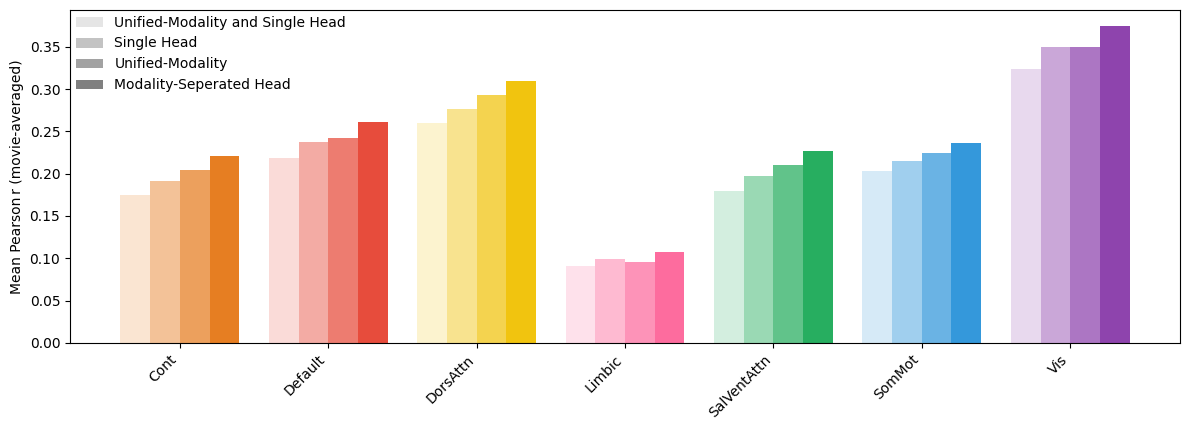

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import OrderedDict

# … assume model_net_scores, pretty, and networks are already defined …

# 1. Use your custom “flat‑UI” network colours
network_colors = {
    "Vis":         "#8e44ad",  # violet
    "SomMot":      "#3498db",  # blue
    "DorsAttn":    "#f1c40f",  # yellow
    "SalVentAttn": "#27ae60",  # green
    "Limbic":      "#fd6c9e",  # pink
     "Cont":        "#e67e22",  # bright orange
    "Default":     "#e74c3c",  # red
}

# 2. Model order → alpha & pretty names
#model_keys   = list(model_net_scores.keys())
selected = ["Ablation1", "Ablation2", "Ablation3", "Non-Ablation"]
model_keys = [k for k in model_net_scores if k in selected]
n_models     = len(model_keys)
model_alphas = np.linspace(0.2, 1.0, n_models)
model_names  = [pretty[k] for k in model_keys]

# 3. Bar positions
x     = np.arange(len(networks))
width = 0.8 / n_models

fig, ax = plt.subplots(figsize=(12, 5))

# 4. Draw bars: network colour + model alpha
for i, key in enumerate(model_keys):
    vals  = [model_net_scores[key].get(net, np.nan) for net in networks]
    alpha = model_alphas[i]
    for j, net in enumerate(networks):
        ax.bar(
            x[j] + i * width,
            vals[j],
            width,
            color=network_colors[net],
            alpha=alpha,
            edgecolor="none",
        )

# 5. Axes tweaks
ax.set_xticks(x + width*(n_models-1)/2)
ax.set_xticklabels(networks, rotation=45, ha="right")
ax.set_ylabel("Mean Pearson r (movie‑averaged)")

model_patches = [
    mpatches.Patch(facecolor="gray", alpha=a, label=name)
    for a, name in zip(model_alphas, model_names)
]
ax.legend(
    handles=model_patches,
    ncol=1,                     # one column → vertical stack
    loc="upper left",           # anchor point
    bbox_to_anchor=(0, 1),      # just above the top‐left corner
    borderaxespad=0,            # no extra padding
    frameon=False,
)
plt.tight_layout()
plt.subplots_adjust(top=0.85)


# 7. Tweak margins so the legend isn’t clipped
plt.tight_layout()
plt.subplots_adjust(top=0.85)            # give the top a bit more room
fig.savefig("ablation.png", dpi=300, bbox_inches="tight")

plt.show()

## Ensemble Models Figure

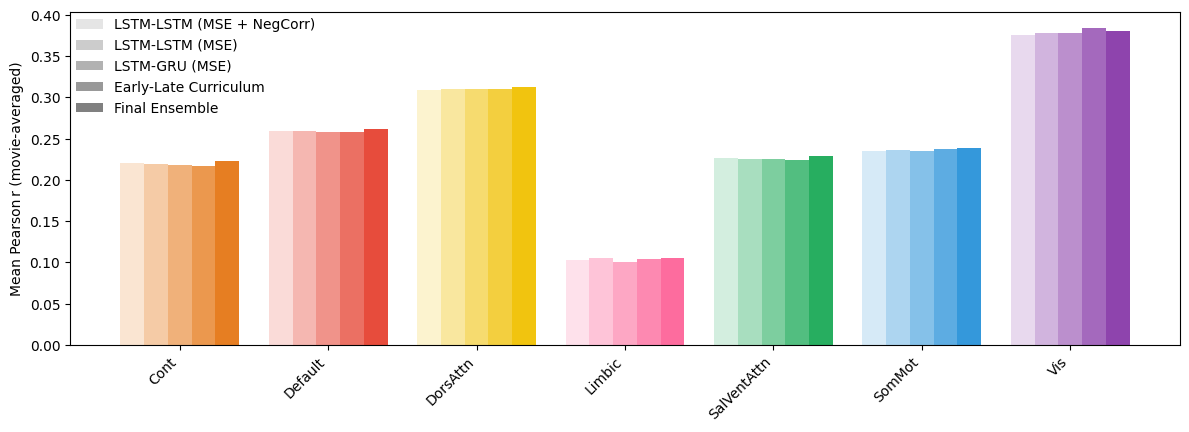

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import OrderedDict


# 1. Use your custom “flat‑UI” network colours
network_colors = {
    "Vis":         "#8e44ad",  # violet
    "SomMot":      "#3498db",  # blue
    "DorsAttn":    "#f1c40f",  # yellow
    "SalVentAttn": "#27ae60",  # green
    "Limbic":      "#fd6c9e",  # pink
     "Cont":        "#e67e22",  # bright orange
    "Default":     "#e74c3c",  # red
}
# 2. Model order → alpha & pretty names
#model_keys   = list(model_net_scores.keys())
selected = ["lstm_lstm_mse_negcorr", "lstm_lstm_mse", "lstm_gru_mse", "lstm_lstm_mse_negcorr", "early_late","final_ensemble"]
model_keys = [k for k in model_net_scores if k in selected]
n_models     = len(model_keys)
model_alphas = np.linspace(0.2, 1.0, n_models)
model_names  = [pretty[k] for k in model_keys]

# 3. Bar positions
x     = np.arange(len(networks))
width = 0.8 / n_models

fig, ax = plt.subplots(figsize=(12, 5))

# 4. Draw bars: network colour + model alpha
for i, key in enumerate(model_keys):
    vals  = [model_net_scores[key].get(net, np.nan) for net in networks]
    alpha = model_alphas[i]
    for j, net in enumerate(networks):
        ax.bar(
            x[j] + i * width,
            vals[j],
            width,
            color=network_colors[net],
            alpha=alpha,
            edgecolor="none",
        )

# 5. Axes tweaks
ax.set_xticks(x + width*(n_models-1)/2)
ax.set_xticklabels(networks, rotation=45, ha="right")
ax.set_ylabel("Mean Pearson r (movie‑averaged)")

model_patches = [
    mpatches.Patch(facecolor="gray", alpha=a, label=name)
    for a, name in zip(model_alphas, model_names)
]
ax.legend(
    handles=model_patches,
    ncol=1,                     # one column → vertical stack
    loc="upper left",           # anchor point
    bbox_to_anchor=(0, 1),      # just above the top‐left corner
    borderaxespad=0,            # no extra padding
    frameon=False,
)
plt.tight_layout()
plt.subplots_adjust(top=0.85)


# 7. Tweak margins so the legend isn’t clipped
plt.tight_layout()
plt.subplots_adjust(top=0.85)            # give the top a bit more room
fig.savefig("ensemble_models.png", dpi=300, bbox_inches="tight")

plt.show()

## Colors on brain

/tmp/ipykernel_1776/3392379155.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  paired = cm.get_cmap("Paired", len(net_order)).colors


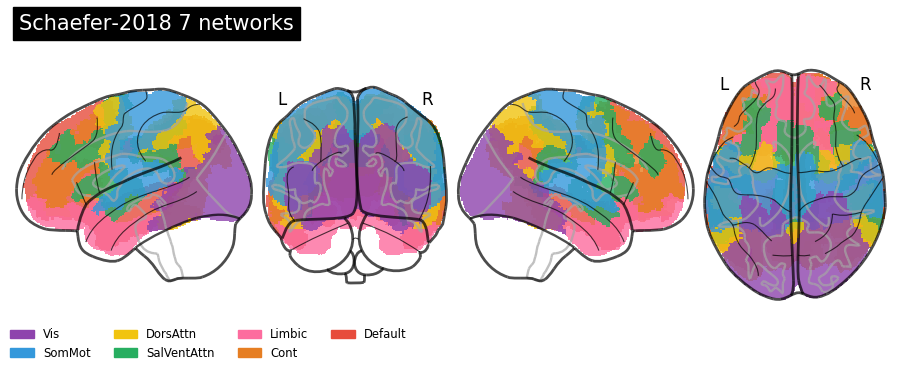

In [13]:

# -------------------------------------------------------------------------
# 0.  Fetch atlas + mappings
# -------------------------------------------------------------------------
atlas_fn = sch["maps"]
labels   = sch["labels"]

def _parcel_to_network(label):
    if isinstance(label, (bytes, bytearray)):
        label = label.decode()
    return label.split("_")[2]

net_order  = ["Vis", "SomMot", "DorsAttn",
              "SalVentAttn", "Limbic", "Cont", "Default"]
net_to_int = {n: i + 1 for i, n in enumerate(net_order)}

# -------------------------------------------------------------------------
# 1.  Paired palette for pastel‑but‑distinct
# -------------------------------------------------------------------------
paired = cm.get_cmap("Paired", len(net_order)).colors
# prettier, pastel‑but‑saturated flat‑UI colours
colors = {
    "Vis":         "#8e44ad",  # violet
    "SomMot":      "#3498db",  # blue
    "DorsAttn":    "#f1c40f",  # yellow
    "SalVentAttn": "#27ae60",  # green
    "Limbic":      "#fd6c9e",  # pink
     "Cont":        "#e67e22",  # bright orange
    "Default":     "#e74c3c",  # red
}


# -------------------------------------------------------------------------
# 2.  Build integer volume
# -------------------------------------------------------------------------
parcel_vals = np.zeros(len(labels), dtype="int16")
for i, lab in enumerate(labels):
    parcel_vals[i] = net_to_int[_parcel_to_network(lab)]

masker  = NiftiLabelsMasker(labels_img=atlas_fn).fit()
vol_int = masker.inverse_transform(parcel_vals)
img_data, affine, header = vol_int.get_fdata(), vol_int.affine, vol_int.header

# -------------------------------------------------------------------------
# 3.  Empty glass‑brain
# -------------------------------------------------------------------------
display = plotting.plot_glass_brain(
    None,
    display_mode="lyrz",
    title="Schaefer‑2018 7 networks",
)

# -------------------------------------------------------------------------
# 4.  Overlay each network with α=0.6
# -------------------------------------------------------------------------
for net in net_order[::-1]:
    mask    = (img_data == net_to_int[net]).astype(np.int8)
    net_img = nib.Nifti1Image(mask, affine, header)
    cmap    = ListedColormap([to_rgba(colors[net])])
    display.add_overlay(
        net_img,
        cmap=cmap,
        threshold=0.5,
        alpha=0.8,
    )


# -------------------------------------------------------------------------
# 5.  Legend in Paired hues
# -------------------------------------------------------------------------
patches = [
    plt.matplotlib.patches.Patch(color=colors[n], label=n)
    for n in net_order
]
plt.gcf().legend(
    handles=patches,
    loc="lower left",
    ncol=4,
    frameon=False,
    fontsize="small"
)
plt.savefig("brain_colors.png", dpi=300, bbox_inches="tight")


plotting.show()
